# Goal of this project is to predict house prices in bangalore.

*First lets import necessary libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
import optuna

C:\Users\Akash\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*We will load the csv file*

In [2]:
df=pd.read_csv('bengaluru_house_prices.csv')
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


## We need to do some data preprocessing on it

*1.We will remove unnecessary columns*

In [3]:
df=df.drop(['area_type',"availability",'balcony','society'],axis=1)
df

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00
...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,231.00
13316,Richards Town,4 BHK,3600,5.0,400.00
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00
13318,Padmanabhanagar,4 BHK,4689,4.0,488.00


*2.We will check for missing values and remove them*

In [4]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

*3.We need to convert size column because size column has inconsistent values*

In [7]:
df["bhk"]=df['size'].apply(lambda x: int(x.split(' ')[0]))
df.drop(['size'],axis=1,inplace=True)
df

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453,4.0,231.00,5
13316,Richards Town,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141,2.0,60.00,2
13318,Padmanabhanagar,4689,4.0,488.00,4


*4.We need to check if values are consistent in total_sqft column*

In [8]:
df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [9]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True
df[~df['total_sqft'].apply(is_float)]

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
...,...,...,...,...,...
12975,Whitefield,850 - 1060,2.0,38.190,2
12990,Talaghattapura,1804 - 2273,3.0,122.000,3
13059,Harlur,1200 - 1470,2.0,72.760,2
13265,Hoodi,1133 - 1384,2.0,59.135,2


*As we can see its not, so we need to convert into float values for consistency*

In [10]:
def convert(x):
    tokens=x.split('-')
    if len(tokens)==2:
        return (float(tokens[0])+float(tokens[0]))/2
    try:
        return float(x)
    except:
        return None
df['total_sqft']=df['total_sqft'].apply(convert)
df

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5
13316,Richards Town,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4689.0,4.0,488.00,4


*5.We need price_per_sqft column as its important to preprocess the data*

In [11]:
df['price_per_sqft']=df['price']*100000/df['total_sqft']
df.dropna(inplace=True)
df['price_per_sqft']=df['price_per_sqft'].astype(int)

*6.There are too many locations with few counts which will unnecessary increase dimensions for prediction so we have to reduce it*

In [12]:
location_stats=df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield                                            532
Sarjapur  Road                                        392
Electronic City                                       302
Kanakpura Road                                        264
Thanisandra                                           232
                                                     ... 
bsk 6th stage 2ad block near sri conversation hall      1
elachenahalli                                           1
kadubisnahalli                                          1
kamanahalli main road                                   1
kanakapura main road                                    1
Name: location, Length: 1298, dtype: int64

In [13]:
len(location_stats[location_stats<=10])

1058

In [14]:
location10=location_stats[location_stats<=10]
location10

location
Nagadevanahalli                                       10
BTM 1st Stage                                         10
Nagappa Reddy Layout                                  10
Sadashiva Nagar                                       10
1st Block Koramangala                                 10
                                                      ..
bsk 6th stage 2ad block near sri conversation hall     1
elachenahalli                                          1
kadubisnahalli                                         1
kamanahalli main road                                  1
kanakapura main road                                   1
Name: location, Length: 1058, dtype: int64

In [15]:
df['location']=df['location'].apply(lambda x: 'other' if x in location10 else x)
df

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615
2,Uttarahalli,1440.0,2.0,62.00,3,4305
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245
4,Kothanur,1200.0,2.0,51.00,2,4250
...,...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5,6689
13316,other,3600.0,5.0,400.00,4,11111
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,5258
13318,Padmanabhanagar,4689.0,4.0,488.00,4,10407


*7.We need to check distribution and remove outliers*

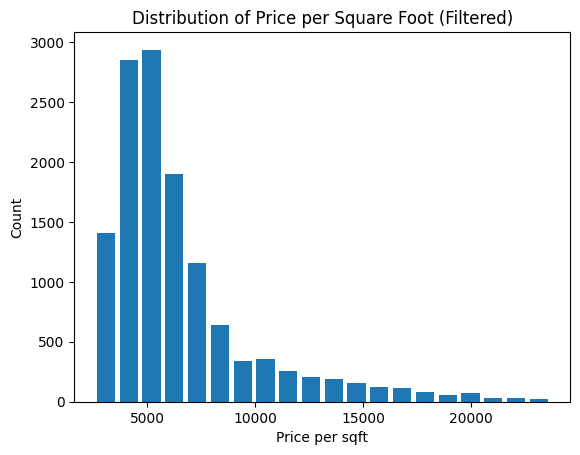

In [16]:
lower_limit = df["price_per_sqft"].quantile(0.01) 
upper_limit = df["price_per_sqft"].quantile(0.99)
df = df[(df["price_per_sqft"] < upper_limit)&(df["price_per_sqft"] > lower_limit)]

plt.hist(df["price_per_sqft"], bins=20, rwidth=0.8)
plt.xlabel("Price per sqft")
plt.ylabel("Count")
plt.title("Distribution of Price per Square Foot (Filtered)")
plt.show()


In [17]:
Q1 = df["price_per_sqft"].quantile(0.25)
Q3 = df["price_per_sqft"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df1 = df[(df["price_per_sqft"] >= lower_bound) & (df["price_per_sqft"] <= upper_bound)]
df1

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615
2,Uttarahalli,1440.0,2.0,62.00,3,4305
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245
4,Kothanur,1200.0,2.0,51.00,2,4250
...,...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5,6689
13316,other,3600.0,5.0,400.00,4,11111
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,5258
13318,Padmanabhanagar,4689.0,4.0,488.00,4,10407


*8.Having more bathrooms than bedroom is uncommon and having more than twice is highly unlikely so we will remove those rows.*

In [18]:
df2=df1[df1.bath<df1.bhk+2]
df2

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615
2,Uttarahalli,1440.0,2.0,62.00,3,4305
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245
4,Kothanur,1200.0,2.0,51.00,2,4250
...,...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5,6689
13316,other,3600.0,5.0,400.00,4,11111
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,5258
13318,Padmanabhanagar,4689.0,4.0,488.00,4,10407


In [19]:
df2 = df2.reset_index(drop=True)
df2

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615
2,Uttarahalli,1440.0,2.0,62.00,3,4305
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245
4,Kothanur,1200.0,2.0,51.00,2,4250
...,...,...,...,...,...,...
11655,Whitefield,3453.0,4.0,231.00,5,6689
11656,other,3600.0,5.0,400.00,4,11111
11657,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2,5258
11658,Padmanabhanagar,4689.0,4.0,488.00,4,10407


*9.We will remove price_per_sqft column as we no longer need it*

In [20]:
df2=df2.drop(["price_per_sqft"],axis=1)
df2

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
...,...,...,...,...,...
11655,Whitefield,3453.0,4.0,231.00,5
11656,other,3600.0,5.0,400.00,4
11657,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
11658,Padmanabhanagar,4689.0,4.0,488.00,4


In [21]:
len(df.location.unique())

241

*10.We need to encode categorical data into numbers as models only understand numbers and remove the categorical column.*

In [22]:
encoder = TargetEncoder()
df2["location_encoded"] = encoder.fit_transform(df2["location"], df2["price"])

In [23]:
df3=df2.drop('location',axis=1)
df3

,total_sqft,bath,price,bhk,location_encoded
0,1056.0,2.0,39.07,2,46.041082
1,2600.0,5.0,120.00,4,98.506677
2,1440.0,2.0,62.00,3,55.413244
3,1521.0,3.0,95.00,3,102.976495
4,1200.0,2.0,51.00,2,92.217681
...,...,...,...,...,...
11655,3453.0,4.0,231.00,5,106.984732
11656,3600.0,5.0,400.00,4,92.161584
11657,1141.0,2.0,60.00,2,61.593423
11658,4689.0,4.0,488.00,4,110.274937


## Preprocessing is done now we need to start building our model.

*1.First lets split into train and test data*

In [24]:
X = df3.drop(columns=["price"]).to_numpy()
y = df3["price"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

*2.We have to choose XGBRegressor model as our data is not linear*

In [25]:
model = XGBRegressor(n_estimators=165, learning_rate=0.15)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=165,
             n_jobs=None, num_parallel_tree=None, ...)

*3.lets predict the score of our model*

In [26]:
model.score(X_test,y_test)

0.8522887236710615

*Our model has done well but still lets check for best parameters using hyperparameter tuning method. We will use optuna for this as it goes weil with XGBRegressor*

In [27]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    

    model = XGBRegressor(**params)
    
    model.fit(X_train,y_train)

    score=model.score(X_test,y_test)
    
    return score 

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best Parameters:", study.best_params)
print("Best Score:", study.best_value)

[I 2025-04-18 16:46:40,471] A new study created in memory with name: no-name-d7a40ebd-67f5-4596-95df-74e18d147e2d
[I 2025-04-18 16:46:41,350] Trial 0 finished with value: 0.8387570367241518 and parameters: {'n_estimators': 373, 'learning_rate': 0.013364451569981504, 'max_depth': 15, 'subsample': 0.8804394825363046, 'colsample_bytree': 0.7232957106295709}. Best is trial 0 with value: 0.8387570367241518.
[I 2025-04-18 16:46:41,458] Trial 1 finished with value: 0.8391791559741032 and parameters: {'n_estimators': 274, 'learning_rate': 0.23518875309416365, 'max_depth': 5, 'subsample': 0.882465859570738, 'colsample_bytree': 0.9755309352951347}. Best is trial 1 with value: 0.8391791559741032.
[I 2025-04-18 16:46:42,456] Trial 2 finished with value: 0.7907738337573356 and parameters: {'n_estimators': 321, 'learning_rate': 0.28589541448701333, 'max_depth': 14, 'subsample': 0.9324372656278901, 'colsample_bytree': 0.9221721585124896}. Best is trial 1 with value: 0.8391791559741032.
[I 2025-04-18 

Best Parameters: {'n_estimators': 82, 'learning_rate': 0.17277201753234117, 'max_depth': 5, 'subsample': 0.77883557224637, 'colsample_bytree': 0.5293692633005871}
Best Score: 0.8591012481795494
